<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_7_densely_connected_networks_dense_net_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [20]:
class ConvBlock(tf.keras.layers.Layer):

  def __init__(self, num_channels):
    
    super(ConvBlock, self).__init__()
    self.bn = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')    
    self.listLayers = [self.bn, self.relu, self.conv]

  def call(self, x):
    y = x
    for layer in self.listLayers.layers:
      y = layer(y)
    y = tf.keras.layers.concatenate([x,y], axis=-1)
    return y

In [21]:
class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, num_convs, num_channels):
    super(DenseBlock, self).__init__()
    self.listLayers = []
    for _ in range(num_convs):
      self.listLayers.append(ConvBlock(num_channels))

  def call(self, x):
    for layer in self.listLayers.layers:
      x = layer(x)
    return x

In [22]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

In [23]:
class TransitionBlock(tf.keras.layers.Layer):

  def __init__(self, num_channels, **kwargs):
    super(TransitionBlock, self).__init__(**kwargs)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
    self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)
  
  def call(self, x):
    x = self.batch_norm(x)
    x = self.relu(x)
    x = self.conv(x)
    return self.avg_pool(x)

In [24]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

In [25]:
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [26]:
def block_2():

  net = block_1()
  num_channels, growth_rate = 64, 32
  num_convs_in_dense_blocks = [4, 4, 4, 4]

  for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
      num_channels //= 2
      net.add(TransitionBlock(num_channels))
  return net

In [27]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))
    
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

In [28]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

In [29]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)

4431872/4422102 [==============================] - 0s 0us/step


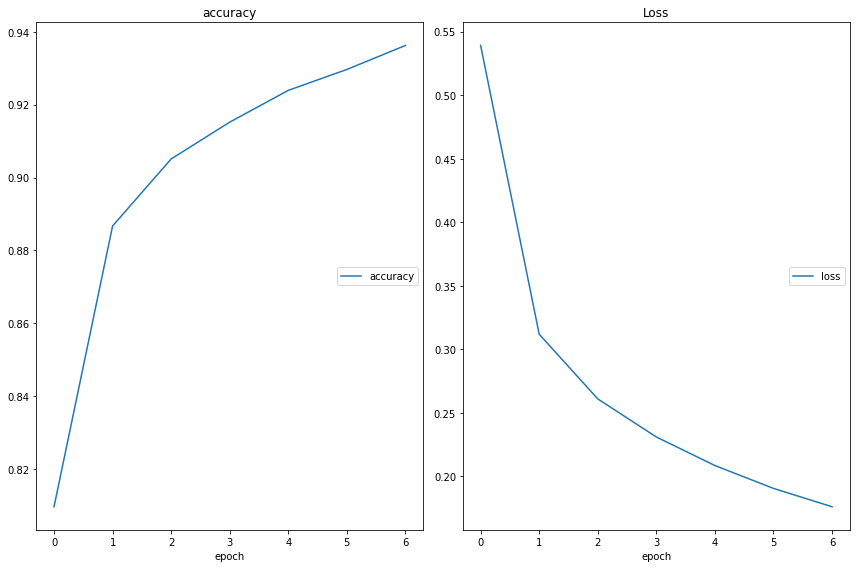

accuracy
	accuracy         	 (min:    0.810, max:    0.936, cur:    0.936)
Loss
	loss             	 (min:    0.176, max:    0.539, cur:    0.176)


In [ ]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())